In [3]:
#gpu
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dados = pd.read_csv('../../Dados/AirPassengers.csv')
normalizador = MinMaxScaler(feature_range=(-1, 1))
dados_normalizados = normalizador.fit_transform(dados["#Passengers"].values.reshape(-1, 1))

In [6]:
class ConjuntoDadosSerieTemporal(Dataset):
    def __init__(self, serie, tamanho_sequencia):
        self.serie = serie
        self.tamanho_sequencia = tamanho_sequencia
    def __len__(self):
        return self.serie.shape[0] - self.tamanho_sequencia
    def __getitem__(self, indice):
        return (self.serie[indice:indice+self.tamanho_sequencia], self.serie[indice+self.tamanho_sequencia])

In [7]:
class CodificacaoPosicional(nn.Module):
    def __init__(self, d_modelo, max_len=5000):
        super(CodificacaoPosicional, self).__init__()

        pe = torch.zeros(max_len, d_modelo)
        posicao = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_modelo, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_modelo))
        pe[:, 0::2] = torch.sin(posicao * div_term)
        pe[:, 1::2] = torch.cos(posicao * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [8]:
class TransformerSerieTemporal(nn.Module):
    def __init__(self, d_modelo, nhead, num_camadas, dropout=0.3):
        super().__init__()
        self.codificacao_posicional = CodificacaoPosicional(d_modelo)
        self.transformer = nn.Transformer(d_model=d_modelo, nhead=nhead, num_encoder_layers=num_camadas,
                                          num_decoder_layers=num_camadas, dim_feedforward=64, dropout=dropout)
        self.fc = nn.Linear(d_modelo, 1)

    def forward(self, x):
        x = x.permute(1, 0, 2)
        x = self.codificacao_posicional(x)
        x = self.transformer(x, x)
        x = self.fc(x.permute(1, 0, 2))
        return x[:, -1, :]

In [9]:
tamanho_sequencia = 12
conjunto_dados = ConjuntoDadosSerieTemporal(torch.FloatTensor(dados_normalizados).squeeze(), tamanho_sequencia)
print(len(conjunto_dados))
print(conjunto_dados[2])

132
(tensor([-0.8919, -0.9035, -0.9344, -0.8803, -0.8301, -0.8301, -0.8764, -0.9421,
        -1.0000, -0.9459, -0.9575, -0.9151]), tensor(-0.8571))


In [10]:
carregador_dados = DataLoader(conjunto_dados, batch_size=16)

In [11]:
modelo = TransformerSerieTemporal(d_modelo=16, nhead=8, num_camadas=4, dropout=0.3)
criterio = nn.MSELoss()
otimizador = optim.Adam(modelo.parameters(), lr=0.001)

c:\Users\lucas.souza\AppData\Local\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [12]:
for epoca in range(100):
    for sequencia, alvo in carregador_dados:
        sequencia = sequencia.unsqueeze(-1)
        alvo = alvo.unsqueeze(-1)

        saida = modelo(sequencia)
        perda = criterio(saida, alvo)

        otimizador.zero_grad()
        perda.backward()
        otimizador.step()
    print(f"Epoch {epoca}: Loss {perda.item()}")

Epoch 0: Loss 0.30337345600128174
Epoch 1: Loss 0.3190191984176636
Epoch 2: Loss 0.25261515378952026
Epoch 3: Loss 0.31238067150115967
Epoch 4: Loss 0.6323941946029663
Epoch 5: Loss 0.08776692301034927
Epoch 6: Loss 0.0879364162683487
Epoch 7: Loss 0.05170794576406479
Epoch 8: Loss 0.034597836434841156
Epoch 9: Loss 0.06677713245153427
Epoch 10: Loss 0.032202836126089096
Epoch 11: Loss 0.2231224924325943
Epoch 12: Loss 0.06615191698074341
Epoch 13: Loss 0.14076028764247894
Epoch 14: Loss 0.030343882739543915
Epoch 15: Loss 0.28672513365745544
Epoch 16: Loss 0.11247328668832779
Epoch 17: Loss 0.13913968205451965
Epoch 18: Loss 0.05381712317466736
Epoch 19: Loss 0.09369855374097824
Epoch 20: Loss 0.034621190279722214
Epoch 21: Loss 0.05431950092315674
Epoch 22: Loss 0.08419707417488098
Epoch 23: Loss 0.044371433556079865
Epoch 24: Loss 0.0883021131157875
Epoch 25: Loss 0.017987972125411034
Epoch 26: Loss 0.029461020603775978
Epoch 27: Loss 0.0941024050116539
Epoch 28: Loss 0.019747469574

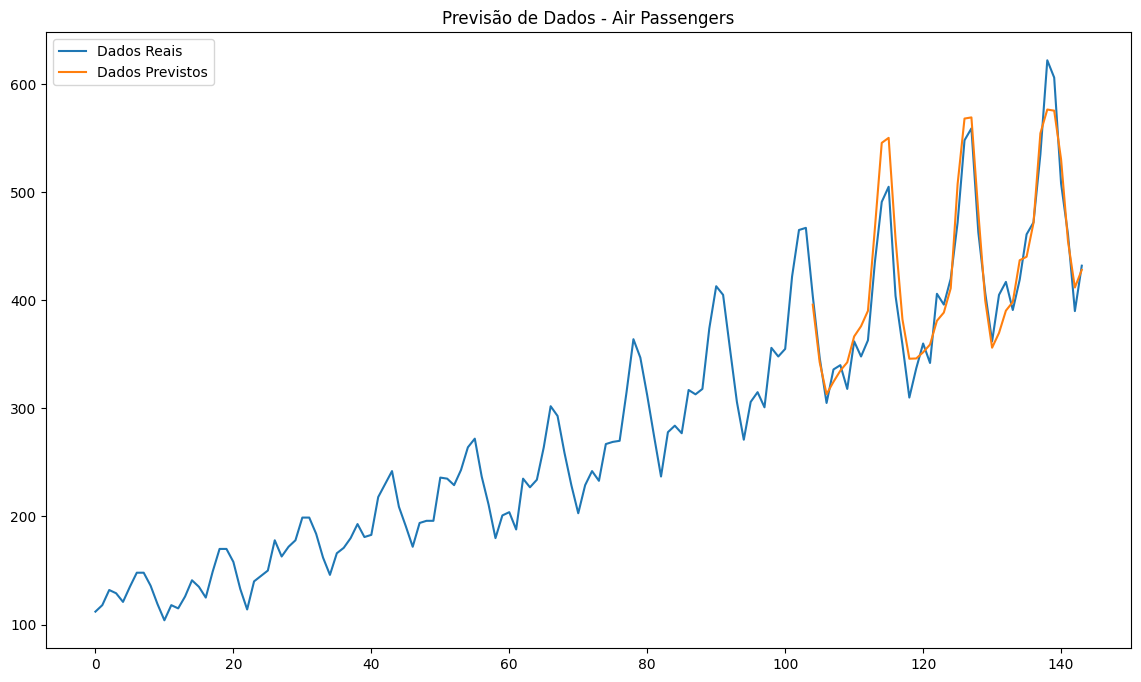

In [10]:
modelo.eval()

with torch.no_grad():
    previsoes = []

    for sequencia, _ in carregador_dados:
        sequencia = sequencia.unsqueeze(-1)
        saida = modelo(sequencia)
        previsoes.append(saida.squeeze(-1).numpy())

previsoes = np.concatenate(previsoes).reshape(-1, 1)
previsoes = normalizador.inverse_transform(previsoes)
dados_reais = normalizador.inverse_transform(dados_normalizados)

tamanho_treinamento = int(len(conjunto_dados) * 0.7)

plt.figure(figsize=(14, 8))
plt.plot(range(len(dados_reais)), dados_reais, label='Dados Reais')
plt.plot(range(tamanho_treinamento + tamanho_sequencia, len(dados_reais)), previsoes[tamanho_treinamento:], label='Dados Previstos')
plt.legend()
plt.title('Previsão de Dados - Air Passengers')
plt.show()